# Решение задачи "Анализ ЭКГ-сигналов для диагностики сердечных патологий" для конкурса AI challenge

Оглавление
- Исследование области задачи
- Обработка и анализ данных
- Тестирование различных моделей

## Исследование области задачи
- SCP-ECG - http://masters.donntu.ru/2008/kita/golovach/library/4_ref/pub.html
- стадии инфаркта

## Обработка и анализ данных

Используемые модули

In [25]:
# Для данных
import pandas as pd
import numpy as np

'''
# Для плюшек
import sklearn as sk
'''

# Для красоты
import seaborn as sns
from pprint import pprint

Полезные функции

In [1]:



def get_hr(folder: str, hr_num: str):
    with open(f'C:/Users/денис/Downloads/ОЛ/{folder}/{hr_num}.npy', "rb") as f:
        return np.load(f, allow_pickle=True)

Пример использования

'\nTODO задача про экг на гитхабе\n'

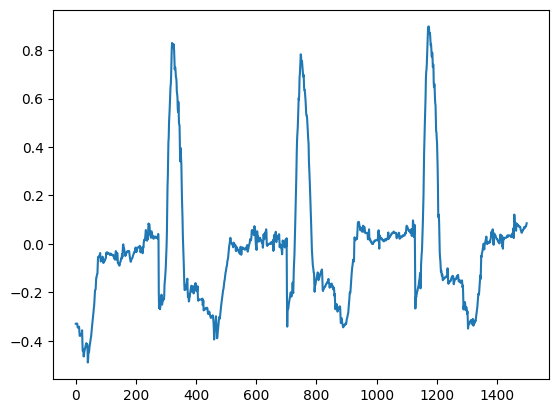

In [32]:
a = get_hr(folder='train', hr_num='15857_hr')
sns.lineplot(data=a.flatten()[:1500])

"""
TODO задача про экг на гитхабе
"""
ecg_columns = ['report', 'scp_codes', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'validated_by', 
'second_opinion', 'initial_autogenerated_report', 'validated_by_human', 'baseline drift', 'static_noise', 'burst_noise', 'electrodes_problems', 
'extra_beats']

Загрузка данных

In [7]:
meta = pd.read_csv('C:/Users/денис/Downloads/ОЛ/train/train_meta.csv')
diagnosis = pd.read_csv('C:/Users/денис/Downloads/ОЛ/train/train_gts.csv')

In [8]:
meta.head(3)

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
0,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,00009_hr,1
1,34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,00034_hr,3
2,43,11315.0,25.0,1,NaN,63.0,2.0,0.0,CS-12 E,1985-03-14 09:38:53,...,NaN,NaN,NaN,NaN,NaN,8,records100/00000/00043_lr,records500/00000/00043_hr,00043_hr,3


In [9]:
diagnosis.head(3)

,record_name,myocard
0,00669_hr,0
1,00209_hr,0
2,00777_hr,0


Просмотрим инофрмацию о нашем датасете </br>
https://physionet.org/content/ptb-xl/1.0.3/ - еще здесь нада

In [10]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        2101 non-null   int64  
 1   patient_id                    2101 non-null   float64
 2   age                           2101 non-null   float64
 3   sex                           2101 non-null   int64  
 4   height                        689 non-null    float64
 5   weight                        905 non-null    float64
 6   nurse                         1947 non-null   float64
 7   site                          2100 non-null   float64
 8   device                        2101 non-null   object 
 9   recording_date                2101 non-null   object 
 10  report                        2101 non-null   object 
 11  scp_codes                     2101 non-null   object 
 12  heart_axis                    1231 non-null   object 
 13  inf

Удалим те данные, которые не несут важной для нас информации

In [11]:
useless_columns = ['ecg_id', 'patient_id', 'nurse', 'site', 'device', 'recording_date', 'filename_lr', 'filename_hr']
meta.drop(columns=useless_columns, inplace=True)

Создадим список тех столбцов, которые возможно не несут важной информации (мы проверим это при обучении)

In [12]:
strange_columns = ['age', 'sex', 'pacemaker', 'group']

Рассмотрим те столбцы, в которых есть много пропусков

In [13]:
for column in meta.columns:
    print(f'Column name: {column} {round(meta[column].notna().sum() / len(meta) * 100, 2)}%')
    print(meta[column].value_counts() if len(meta[column].unique()) < 14 else f'so much unique values\n{meta[column].describe()}')
    print()

Column name: age 100.0%
so much unique values
count    2101.000000
mean       62.581152
std        31.758759
min         3.000000
25%        50.000000
50%        61.000000
75%        72.000000
max       300.000000
Name: age, dtype: float64

Column name: sex 100.0%
sex
0    1095
1    1006
Name: count, dtype: int64

Column name: height 32.79%
so much unique values
count    689.000000
mean     167.343977
std       10.479595
min      100.000000
25%      160.000000
50%      167.000000
75%      175.000000
max      209.000000
Name: height, dtype: float64

Column name: weight 43.07%
so much unique values
count    905.000000
mean      71.605525
std       15.397469
min       16.000000
25%       61.000000
50%       70.000000
75%       80.000000
max      180.000000
Name: weight, dtype: float64

Column name: report 100.0%
so much unique values
count                          2101
unique                         1242
top       sinus rhythm. normal ecg.
freq                            177
Name: report,

На основе этих данных выделим список столбцов с множество недостающих значений

In [14]:
empty_columns = ['height', 'weight', 'heart_axis']
meta.drop(columns=empty_columns, inplace=True)

Удалим те строки, в которых electrodes_problem

In [15]:
meta.drop(meta[meta['electrodes_problems'].notna()].index, inplace=True)
meta.drop(columns=['electrodes_problems'], inplace=True)
meta.drop(1514, inplace=True) # Хех пока

In [16]:
meta = meta.reset_index(drop=True)

In [17]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           2096 non-null   float64
 1   sex                           2096 non-null   int64  
 2   report                        2096 non-null   object 
 3   scp_codes                     2096 non-null   object 
 4   infarction_stadium1           507 non-null    object 
 5   infarction_stadium2           10 non-null     object 
 6   validated_by                  1239 non-null   float64
 7   second_opinion                2096 non-null   bool   
 8   initial_autogenerated_report  2096 non-null   bool   
 9   validated_by_human            2096 non-null   bool   
 10  baseline_drift                150 non-null    object 
 11  static_noise                  308 non-null    object 
 12  burst_noise                   41 non-null     object 
 13  ext

Отдельно рассмотрим столбец report, т.к. его нужно по особому обрабатывать

In [18]:
reports = meta['report'].tolist()

In [19]:
print(len(reports))
print(len(list(filter(lambda st: 'unbestÄtigter bericht' in st, reports)))) # неподтвержденные

2096
626


In [23]:
import stanza

ppln = stanza.Pipeline('de', processors='tokenize,pos,lemma')

2023-08-13 14:43:34 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-08-13 14:43:34 WARNING: Language de package default expects mwt, which has been added
2023-08-13 14:44:53 INFO: Loading these models for language: de (German):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |

2023-08-13 14:44:53 INFO: Using device: cpu
2023-08-13 14:44:53 INFO: Loading: tokenize
2023-08-13 14:44:53 INFO: Loading: mwt
2023-08-13 14:44:53 INFO: Loading: pos
2023-08-13 14:44:54 INFO: Loading: lemma
2023-08-13 14:44:54 INFO: Done loading processors!


In [24]:
subrs = set()
prc = 0

for ind, report in enumerate(reports):
    doc = ppln(report)

    signs = ['!', ',', '.', ')', '(', ':']

    lemmas = []

    for sentence in doc.sentences:
        lemmas += [word.lemma if word.lemma not in signs else '' for word in sentence.words]

    
    subrs = subrs.union(set(filter(lambda x: x, lemmas)))
    if prc != round((ind+1)/len(reports)*100,1):
        prc = round((ind+1)/len(reports)*100, 1)
        print(prc)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9


KeyboardInterrupt: 

In [ ]:
print(subrs, len(subrs))

In [ ]:
#TUT

Заменим строки в названиях, так как они малину портят

In [11]:
str_columns = ['infarction_stadium1', 'infarction_stadium2', 'burst_noise', 'pacemaker']

meta = pd.get_dummies(meta, columns=str_columns)

In [15]:
"""
TODO у нас еще остались столбцы baseline_drift static_noise extra_beats, scp_codes с не числовым типом
"""
meta['scp_codes'].unique()

array(["{'NORM': 100.0, 'SR': 0.0}", "{'AFLT': 100.0}",
       "{'IRBBB': 100.0, 'SR': 0.0}", "{'LVH': 100.0, 'SR': 0.0}",
       "{'NORM': 80.0, 'STACH': 0.0}", "{'NDT': 100.0, 'SR': 0.0}",
       "{'ASMI': 50.0, 'ABQRS': 0.0, 'SR': 0.0}",
       "{'NORM': 80.0, 'SR': 0.0}", "{'PACE': 100.0}",
       "{'LAFB': 100.0, 'SR': 0.0}", "{'NST_': 100.0, 'SR': 0.0}",
       "{'NST_': 100.0, 'PVC': 100.0, 'SR': 0.0}",
       "{'CRBBB': 100.0, 'LAFB': 100.0, 'SR': 0.0}",
       "{'IMI': 15.0, 'ABQRS': 0.0, 'SR': 0.0}",
       "{'NDT': 100.0, '1AVB': 100.0, 'SR': 0.0}",
       "{'IMI': 100.0, 'CRBBB': 100.0, 'PAC': 0.0, 'LPR': 0.0, 'QWAVE': 0.0, 'SR': 0.0}",
       "{'NORM': 100.0, 'SARRH': 0.0}",
       "{'LVH': 100.0, 'ISC_': 100.0, 'PVC': 100.0, 'NST_': 0.0, 'AFLT': 0.0, 'SVTAC': 0.0}",
       "{'LAFB': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",
       "{'LVH': 100.0, 'ISC_': 100.0}",
       "{'NORM': 80.0, 'PAC': 0.0, 'SR': 0.0}",
       "{'IRBBB': 80.0, 'SR': 0.0}",
       "{'NORM': 80.0, 'IRBBB': 1

TODO подробно описать каждый оставшийся столбец

In [16]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 48 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 2096 non-null   float64
 1   sex                                 2096 non-null   int64  
 2   report                              2096 non-null   object 
 3   scp_codes                           2096 non-null   object 
 4   validated_by                        1239 non-null   float64
 5   second_opinion                      2096 non-null   bool   
 6   initial_autogenerated_report        2096 non-null   bool   
 7   validated_by_human                  2096 non-null   bool   
 8   baseline_drift                      150 non-null    object 
 9   static_noise                        308 non-null    object 
 10  extra_beats                         174 non-null    object 
 11  strat_fold                          2096 no

...

## Тестирование различных моделей

Используемые модули (не точно)

In [ ]:
# Нейронки (какие-то уберем, разобраться сначала, какие для этого подходят)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVR

# Посложнее, что успеем сделать
import torch #1
import keras #2

# Метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score